In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV

from plotting import Plotting
from lasso import Lasso

In [2]:
#scoring = 'r2'
#scoring_neg = False
#scoring_label = 'R²'
#scoring_label_loss = 'R²'

scoring = 'neg_mean_squared_error'
scoring_neg = True
scoring_label = 'MSE'
scoring_label_loss = 'Squared loss'

In [3]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [4]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

In [5]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

In [6]:
useLabelEncoder = False
useColumnCat = True

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)
elif useColumnCat:
    # genera le colonne per ogni elemento di una colonna categoria
    columns_categories = pandas.DataFrame()

    for c in categories_columns:
        column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')        
        columns_categories = pandas.concat((columns_categories, column), axis=1)

    for col in columns_categories.columns: 
        numerics_columns.append(col)
        
    # elimina le colonne categoria
    data_frame.drop(columns=categories_columns, inplace=True)

    # aggiungi le colonne per ogni elemento di una colonna categoria
    data_frame = pandas.concat([data_frame, columns_categories], axis=1)
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND', 'NEAR BAY'], [1, 20, 100, 1500, 500], inplace=True)
    numerics_columns.append('ocean_proximity')

In [7]:
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [8]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


Quindi la nostra attuale y è la seguente:

In [9]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [10]:
column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
cols = list(range(0, data_frame.shape[1]))
cols.remove(column_to_predict_idx)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [11]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


In [12]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1986)

print('Train size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Train size: 16512
Test size: 4128


In [14]:
lasso = Lasso()

In [15]:
alphas = numpy.sort(numpy.logspace(-5, -0.1, 20)) * 30
alphas

array([3.00000000e-04, 5.43270335e-04, 9.83808858e-04, 1.78158056e-03,
       3.22626623e-03, 5.84244912e-03, 1.05800976e-02, 1.91595106e-02,
       3.46959793e-02, 6.28309876e-02, 1.13780706e-01, 2.06045607e-01,
       3.73128220e-01, 6.75698311e-01, 1.22362283e+00, 2.21585995e+00,
       4.01270325e+00, 7.26660881e+00, 1.31591100e+01, 2.38298470e+01])

### Validation curve
Determine training and test scores for varying parameter values.

Compute scores for an estimator with different values of a specified parameter. This is similar to grid search with one parameter. However, this will also compute training scores and is merely a utility for plotting the results.

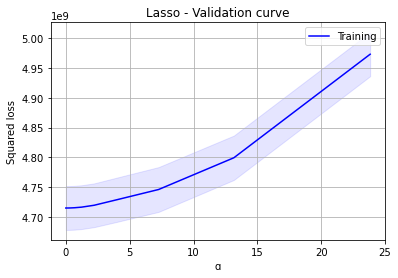

Best ɑ: 0.0003000000


In [16]:
train_score, test_scores = validation_curve(lasso, x_train, y_train, param_name="alpha", param_range=alphas, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd1(
    'Lasso - Validation curve',
    alphas,
    train_score,
    scoring_neg,
    'Training',
    'b',
    'ɑ',
    scoring_label_loss)

best_ɑ = alphas[numpy.argmax(train_score.mean(axis=1))]
lasso.alpha = best_ɑ
print('Best ɑ:', "{:.10f}".format(best_ɑ))

### Learning curve
Determines cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

In [17]:
min_ts = int(x_train.shape[0] * 0.01)
max_ts = int(x_train.shape[0] * 0.8)
step_ts = int(x_train.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(165, 13209, 1651)


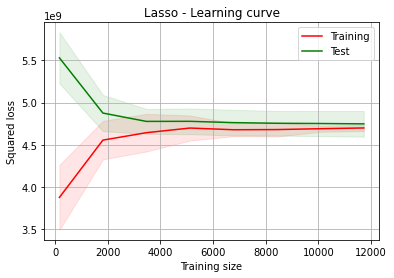

In [18]:
train_size, train_score, test_scores = learning_curve(lasso, x_train, y_train, train_sizes=sizes, shuffle=True, random_state=1986, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Lasso - Learning curve',
    train_size,
    [train_score, test_scores],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

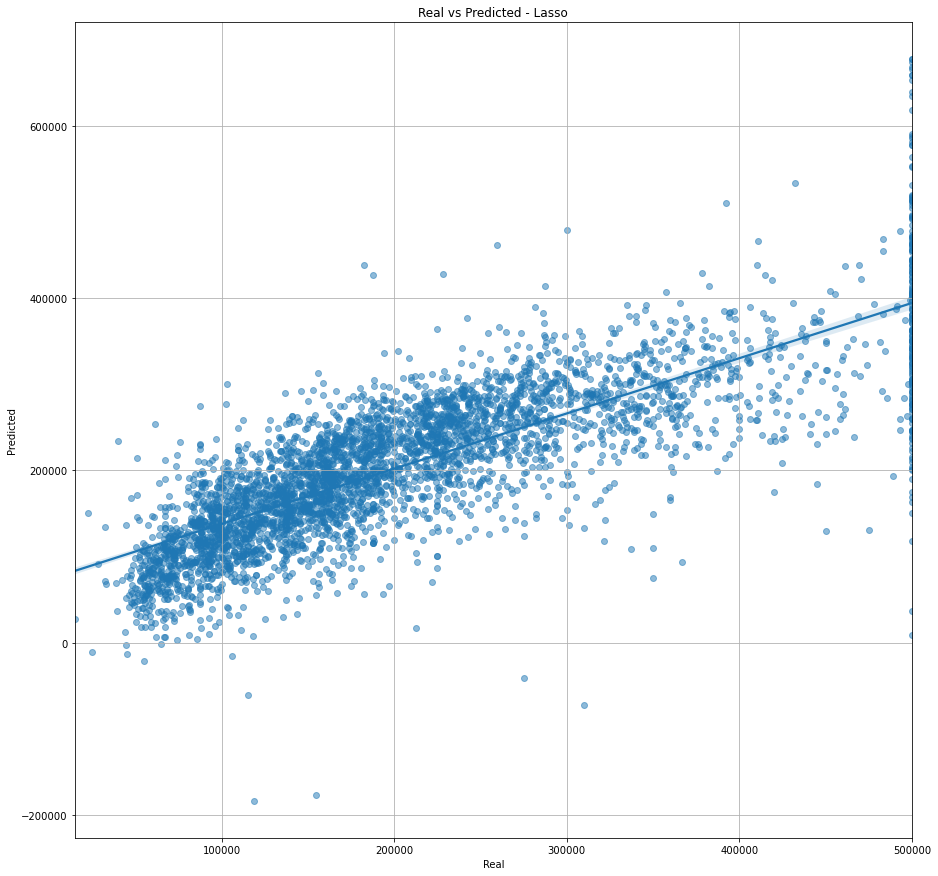

In [19]:
lasso.fit(x_train, y_train)
y_predict_c = lasso.predict(x_test)
Plotting.regPlot('Lasso', y_predict_c, y_test)

## Nested Cross validation
### GridSearchCV
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [20]:
lasso.alphas = alphas
scores = lasso.nestedCrossValidation(x_train, y_train, scoring)

print('Accuracy: %.3f (%.3f)' % (numpy.mean(-scores), numpy.std(-scores)))

Accuracy: 4750606547.494 (266258290.136)
